In [50]:
import pandas as pd
import yaml
import plotly.express as px
import matplotlib.pyplot as plt

with open('../plfs/perv1.map.yaml', 'r') as fin:
    schema = yaml.safe_load(fin)

df = pd.read_parquet('data/perv1.parquet')
MULT = 'subsample_multiplier'
df.head()

stratum  \
year_quarter visit sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number           
Q1           V1    rural  10002 1                   1                           01                      01                        01   
                                                                                                        02                        01   
                                                                                                        03                        01   
                                                                                                        04                        01   
                                                                                                        05                        01   

                                                                                                                             sub_stratum  \
year_quarter visit sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number               
Q1           V1    rural  10002 1                   1                           01                      01                            14   
                                                                                                        02                            14   
                                                                                                        03                            14   
                                                                                                        04                            14   
                                                                                                        05                            14   

                                                                                                                             sub_sample  \
year_quarter visit sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number              
Q1           V1    rural  10002 1                   1                           01                      01                            1   
                                                                                                        02                            1   
                                                                                                        03                            1   
                                                                                                        04                            1   
                                                                                                        05                            1   

                                                                                                                             fod_sub_region  \
year_quarter visit sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number                  
Q1           V1    rural  10002 1                   1                           01                      01                             0213   
                                                                                                        02                             0213   
                                                                                                        03                             0213   
                                                                                                        04                             0213   
                                                                                                        05                             0213   

                                                                                                                              ns_count_sector_stratum_substratum_subsample  \
year_quarter visit sector fsu   sample_sg

In [55]:
# Working age
codes = {v: k for k, v in schema['b6q5_perv1']['categories'].items()}

SELF_EMPLOYED = [11, 12, 21, 61, 62]
SALARIED = [31, 71, 72]
CASUAL = [41, 42, 51]
UNEMPLOYED = [81]
df['cws'] = df['current_weekly_status_code'].map(codes).fillna('99').astype(int)
df['wf_status'] = "Not in Workforce"
df.loc[df['cws'].isin(SELF_EMPLOYED), 'wf_status'] = 'Self Employed'
df.loc[df['cws'].isin(SALARIED), 'wf_status'] = 'Salaried'
df.loc[df['cws'].isin(CASUAL), 'wf_status'] = 'Casual Labour'
df.loc[df['cws'].isin(UNEMPLOYED), 'wf_status'] = 'Unemployed'
df['sector'] = df.index.get_level_values(2).str.title()
df['gender'] = df['gender'].str.title()

xdf = df[df['age'] >= 15]
xdf = xdf[xdf['age'] <= 65].copy()


In [ ]:
xdf['income'] = 0

In [61]:
ydf = xdf[['sector', 'gender', 'wf_status', MULT]]

ydf.index = range(len(ydf))
zdf = ydf.groupby(['sector', 'gender', 'wf_status']).apply(lambda x: x[MULT].sum() / ydf[MULT].sum()).reset_index()
zdf['pc'] = zdf.pop(0) * 100
zdf['label'] = zdf['wf_status'] + " " + zdf['pc'].map('({:.2f}%)'.format)

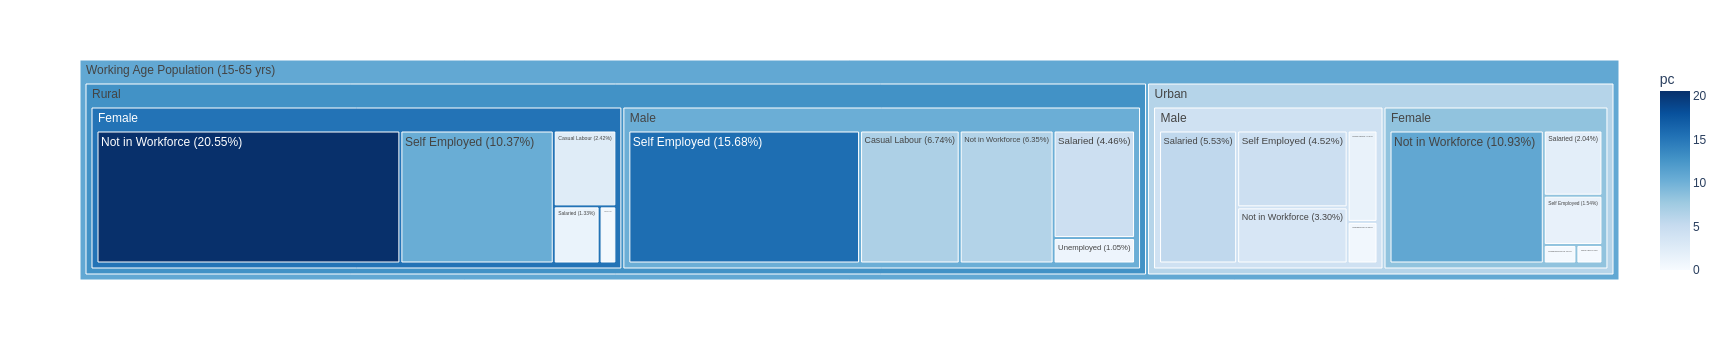

In [76]:
px.treemap(zdf, path=[px.Constant("Working Age Population (15-65 yrs)"), "sector", "gender", "label"], values='pc', color='pc', color_continuous_scale='Blues')

In [79]:
zdf.to_clipboard()

In [84]:
# Urban males, incomes
xdf.loc[xdf['general_education'] == 'others', 'general_education'] = "literate without formal schooling: others"
xdf['broad_edu'] = xdf['general_education']
xdf.loc[xdf['general_education'].str.startswith('literate without formal schooling'), 'broad_edu'] = 'literate without formal schooling'
xdf['broad_edu'].unique()

array(['primary', 'secondary', 'middle', 'higher secondary',
       'not literate', 'below primary', 'diploma/certificate course',
       'graduate', 'postgraduate and above',
       'literate without formal schooling'], dtype=object)

In [85]:
educat = pd.CategoricalDtype(
    ['not literate', 'literate without formal schooling', 'below primary',
     'primary', 'secondary', 'middle', 'higher secondary', 'diploma/certificate course',
     'graduate', 'postgraduate and above'],
ordered=True)
xdf['broad_edu'] = xdf['broad_edu'].astype(educat)
xdf['wf_status'].unique()

array(['Not in Workforce', 'Self Employed', 'Salaried', 'Casual Labour',
       'Unemployed'], dtype=object)

In [114]:
# rural males
ydf = xdf[xdf['wf_status'].isin(['Self Employed', 'Salaried', 'Casual Labour'])]
yrdf = ydf[ydf['gender'] == 'Male']
yrdf = yrdf[yrdf['sector'] == 'Rural']


rsalaried = yrdf[yrdf['wf_status'] == 'Salaried'].groupby('broad_edu')['weekly_salaried_earnings'].mean()
rselfemp = yrdf[yrdf['wf_status'] == 'Self Employed'].groupby('broad_edu')['weekly_self_employed_earnings'].mean()
rcasual = yrdf[yrdf['wf_status'] == 'Casual Labour'].groupby('broad_edu').apply(lambda x: x[[c for c in x if c.startswith('wage_earned_')]].sum(axis=1).mean() * 4)
pdfr_income = pd.concat([rcasual, rsalaried, rselfemp], axis=1)
pdfr_income.columns = ['Casual Labour', 'Salaried', 'Self Employed']
pdfr_sizes = yrdf.groupby(['broad_edu', 'wf_status']).apply(lambda x: x[MULT].sum() / yrdf[MULT].sum()).unstack()

/tmp/ipykernel_12144/1796321502.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_12144/1796321502.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_12144/1796321502.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_12144/1796321502.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=

/tmp/ipykernel_12144/22200127.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_12144/22200127.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_12144/22200127.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_12144/22200127.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to

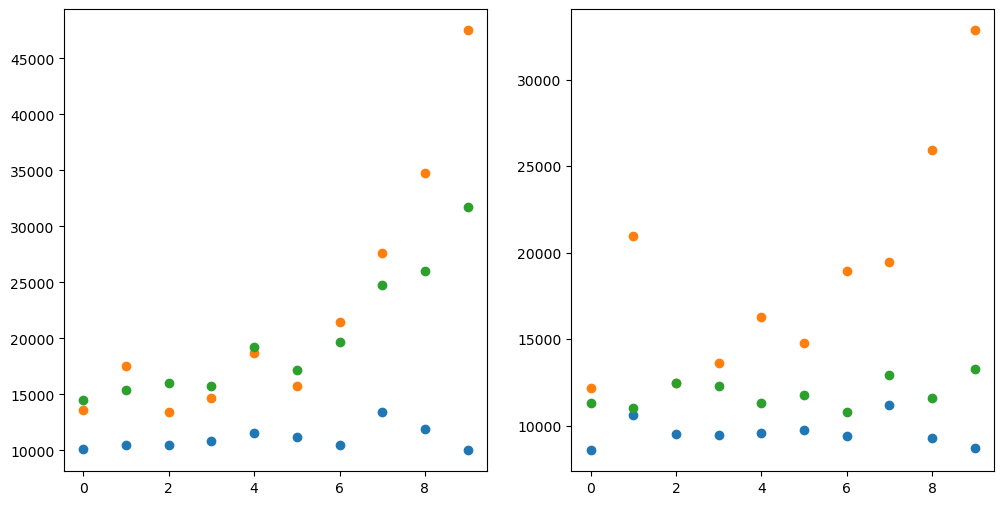

In [145]:
ydf = xdf[xdf['wf_status'].isin(['Self Employed', 'Salaried', 'Casual Labour'])]
ydf = ydf[ydf['gender'] == 'Male']
ydf = ydf[ydf['sector'] == 'Urban']


salaried = ydf[ydf['wf_status'] == 'Salaried'].groupby('broad_edu')['weekly_salaried_earnings'].mean()
selfemp = ydf[ydf['wf_status'] == 'Self Employed'].groupby('broad_edu')['weekly_self_employed_earnings'].mean()
casual = ydf[ydf['wf_status'] == 'Casual Labour'].groupby('broad_edu').apply(lambda x: x[[c for c in x if c.startswith('wage_earned_')]].sum(axis=1).mean() * 4)
pdf_income = pd.concat([casual, salaried, selfemp], axis=1)
pdf_income.columns = ['Casual Labour', 'Salaried', 'Self Employed']
pdf_sizes = ydf.groupby(['broad_edu', 'wf_status']).apply(lambda x: x[MULT].sum() / ydf[MULT].sum()).unstack()
# ax = pdf_income.plot()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for col in pdf_sizes:
    ax[0].scatter(range(len(pdf_sizes)), pdf_income[col], marker='o', alpha=1)
    ax[1].scatter(range(len(pdfr_sizes)), pdfr_income[col], marker='o', alpha=1)

In [119]:
import seaborn as sns

In [147]:
ydf = xdf[xdf['wf_status'].isin(['Self Employed', 'Salaried', 'Casual Labour'])]
ydf = ydf[ydf['gender'] == 'Male']
ydf = ydf[ydf['sector'] == 'Urban']

ydf['income'] = 0

In [148]:
ydf.loc[ydf['wf_status'] == 'Salaried', 'income'] = ydf[ydf['wf_status'] == 'Salaried']['weekly_salaried_earnings']
ydf.loc[ydf['wf_status'] == 'Self Employed', 'income'] = ydf[ydf['wf_status'] == 'Self Employed']['weekly_self_employed_earnings']
ydf.loc[ydf['wf_status'] == 'Casual Labour', 'income'] = ydf[ydf['wf_status'] == 'Casual Labour'][[c for c in ydf if c.startswith('wage_earned_')]].sum(axis=1) * 4

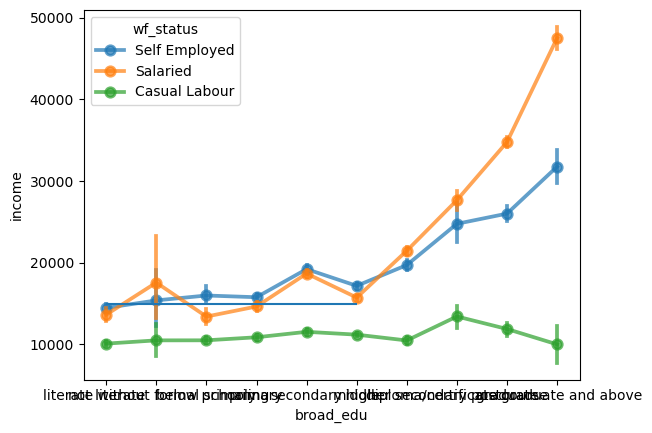

In [158]:
ax = sns.pointplot(ydf, x='broad_edu', y='income', hue='wf_status', alpha=0.7)
ax.hlines(15000, 0, 5)

In [161]:
# social group
hdf = pd.read_parquet('data/hhv1.parquet')
hdf.head()

visit  \
yr_quarter sector FSU   sample-sg-sb-no second-stage-stratum-no sample-hh-no         
Q1         rural  10002 1               1                       01              V1   
                                        2                       01              V1   
                                                                02              V1   
                                        3                       01              V1   
                        2               1                       01              V1   

                                                                                         state  \
yr_quarter sector FSU   sample-sg-sb-no second-stage-stratum-no sample-hh-no                     
Q1         rural  10002 1               1                       01            Himachal Pradesh   
                                        2                       01            Himachal Pradesh   
                                                                02            Himachal Pradesh   
                                        3                       01            Himachal Pradesh   
                        2               1                       01            Himachal Pradesh   

                                                                             district  \
yr_quarter sector FSU   sample-sg-sb-no second-stage-stratum-no sample-hh-no            
Q1         rural  10002 1               1                       01                 04   
                                        2                       01                 04   
                                                                02                 04   
                                        3                       01                 04   
                        2               1                       01                 04   

                                                                             nss-region  \
yr_quarter sector FSU   sample-sg-sb-no second-stage-stratum-no sample-hh-no              
Q1         rural  10002 1               1                       01                  021   
                                        2                       01                  021   
                                                                02                  021   
                                        3                       01                  021   
                        2               1                       01                  021   

                                                                             stratum  \
yr_quarter sector FSU   sample-sg-sb-no second-stage-stratum-no sample-hh-no           
Q1         rural  10002 1               1                       01                01   
                                        2                       01                01   
                                                                02                01   
                                        3                       01                01   
                        2               1                       01                01   

                                                                             sub-stratum  \
yr_quarter sector FSU   sample-sg-sb-no second-stage-stratum-no sample-hh-no               
Q1         rural  10002 1               1                       01                    14   
                                        2                       01                    14   
                                                                02                    14   
                                        3                       01                    14   
                        2               1                       01                    14   

                                                                             sub-sample  \
yr_quarter sector FSU   sample-sg-sb-no second-stage-stratum-no sample-hh-no              
Q1         rural  10002 1               1                       01               

In [166]:
sg = hdf['social_group']
sg.index[0]

('Q1', 'rural', '10002', '1', '1', '01')

In [179]:
df = df.droplevel(1)

In [185]:
df['social_group'] = ''
for ix, caste in sg.items():
    df.loc[ix + (slice(None),), 'social_group'] = caste

In [205]:
df['broad_edu'] = df['general_education']
df.loc[df['general_education'].str.startswith('literate without formal schooling'), 'broad_edu'] = 'literate without formal schooling'
df['broad_edu'] = df['broad_edu'].astype(educat)

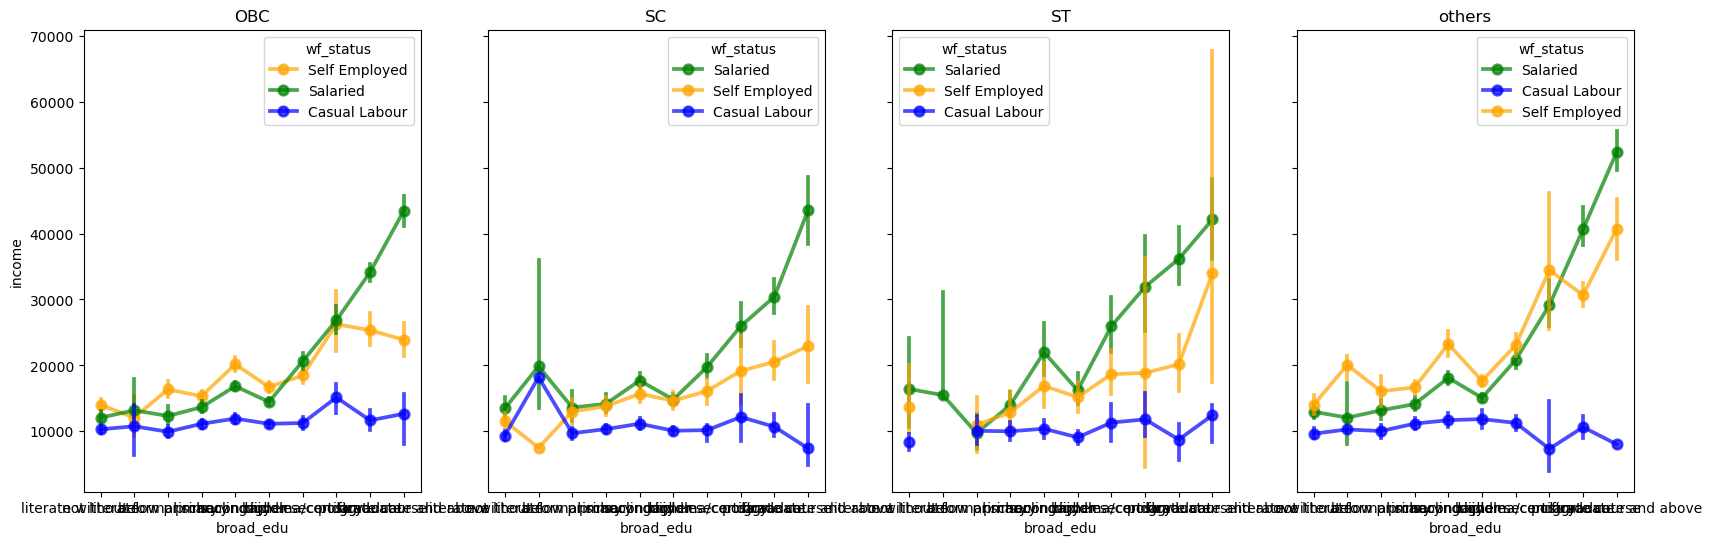

In [212]:
# Urban males in the workforce
xdf = df[df['sector'] == 'Urban']
xdf = xdf[xdf['gender'] == 'Male']
xdf = xdf[xdf['age'] >= 15]
xdf = xdf[xdf['age'] <= 65]
xdf = xdf[xdf['cws'].isin(SELF_EMPLOYED + SALARIED + CASUAL)]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), sharey=True)
for (caste, ydf), ax in zip(xdf.groupby('social_group'), axes):
    ydf['income'] = 0
    ydf.loc[ydf['wf_status'] == 'Salaried', 'income'] = ydf[ydf['wf_status'] == 'Salaried']['weekly_salaried_earnings']
    ydf.loc[ydf['wf_status'] == 'Self Employed', 'income'] = ydf[ydf['wf_status'] == 'Self Employed']['weekly_self_employed_earnings']
    ydf.loc[ydf['wf_status'] == 'Casual Labour', 'income'] = ydf[ydf['wf_status'] == 'Casual Labour'][[c for c in ydf if c.startswith('wage_earned_')]].sum(axis=1) * 4
    sns.pointplot(ydf, x='broad_edu', y='income', hue='wf_status', alpha=0.7, ax=ax, palette={'Salaried': "green", "Self Employed": "orange", "Casual Labour": "blue"}, weights=MULT)
    ax.set_title(caste)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

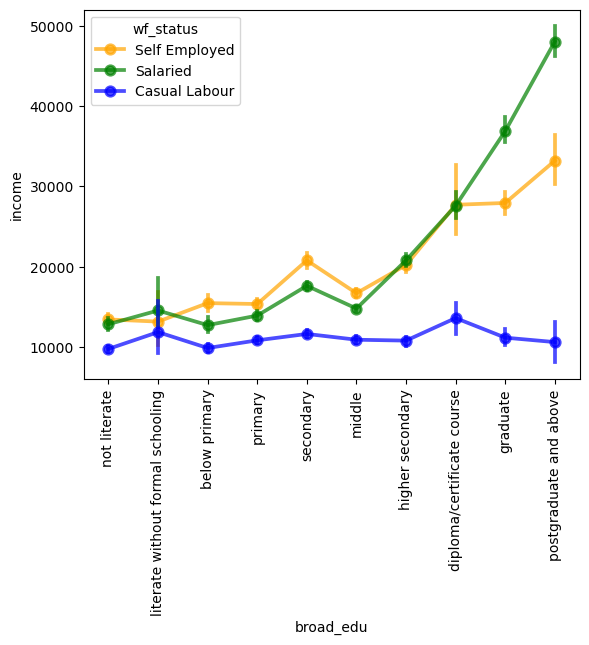

In [216]:
xdf['income'] = 0
xdf.loc[xdf['wf_status'] == 'Salaried', 'income'] = xdf[xdf['wf_status'] == 'Salaried']['weekly_salaried_earnings']
xdf.loc[xdf['wf_status'] == 'Self Employed', 'income'] = xdf[xdf['wf_status'] == 'Self Employed']['weekly_self_employed_earnings']
xdf.loc[xdf['wf_status'] == 'Casual Labour', 'income'] = xdf[xdf['wf_status'] == 'Casual Labour'][[c for c in ydf if c.startswith('wage_earned_')]].sum(axis=1) * 4
ax = sns.pointplot(xdf, x='broad_edu', y='income', hue='wf_status', alpha=0.7, palette={'Salaried': "green", "Self Employed": "orange", "Casual Labour": "blue"}, weights=MULT)
plt.xticks(rotation=90)

In [217]:
## Those who don't consider education necessary

In [218]:
df.shape

(418159, 134)

In [221]:
df['edu_necessity'] = df['current_attendance_educational_inst'].isin(['03', '13'])

In [223]:
xdf = df[df['sector'] == 'Urban']
xdf = xdf[xdf['gender'] == 'Male']
xdf = xdf[xdf['age'] >= 15]
xdf = xdf[xdf['age'] <= 65]
xdf.head()

stratum  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number           
Q1           urban  20006 1                   1                           01                      01                        01   
                                                                                                  03                        01   
                                                                          02                      04                        01   
                                                                                                  06                        01   
                                              2                           01                      03                        01   

                                                                                                                       sub_stratum  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number               
Q1           urban  20006 1                   1                           01                      01                            01   
                                                                                                  03                            01   
                                                                          02                      04                            01   
                                                                                                  06                            01   
                                              2                           01                      03                            01   

                                                                                                                       sub_sample  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number              
Q1           urban  20006 1                   1                           01                      01                            2   
                                                                                                  03                            2   
                                                                          02                      04                            2   
                                                                                                  06                            2   
                                              2                           01                      03                            2   

                                                                                                                       fod_sub_region  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number                  
Q1           urban  20006 1                   1                           01                      01                             3332   
                                                                                                  03                             3332   
                                                                          02                      04                             3332   
                                                                                                  06                             3332   
                                              2                           01                      03                             3332   

                                                                                                                        ns_count_sector_stratum_substratum_subsample  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number                                                 
Q1           urban  20006 1              

In [230]:
xdf['income'] = 0
xdf = xdf[xdf['wf_status'].isin(['Casual Labour', 'Salaried', 'Self Employed'])]

xdf.loc[xdf['wf_status'] == 'Salaried', 'income'] = xdf[xdf['wf_status'] == 'Salaried']['weekly_salaried_earnings']
xdf.loc[xdf['wf_status'] == 'Self Employed', 'income'] = xdf[xdf['wf_status'] == 'Self Employed']['weekly_self_employed_earnings']
xdf.loc[xdf['wf_status'] == 'Casual Labour', 'income'] = xdf[xdf['wf_status'] == 'Casual Labour'][[c for c in ydf if c.startswith('wage_earned_')]].sum(axis=1) * 4


xdf.groupby(['edu_necessity', 'wf_status'])['income'].mean().unstack()

wf_status,Casual Labour,Salaried,Self Employed
edu_necessity,,,
False,10943.723668,25709.781805,19877.381318
True,8698.095238,13750.085470,9518.103448


In [250]:
# qualifications of drivers
drivers = xdf[xdf['weekly_industry_nic'] == '49']
drivers = xdf[xdf['weekly_occupation_nco'] == '832']
xx = drivers.groupby('general_education').apply(lambda x: x[MULT].sum() / drivers[MULT].sum())
xx.index = xx.index.astype(educat)

<AxesSubplot:xlabel='general_education'>

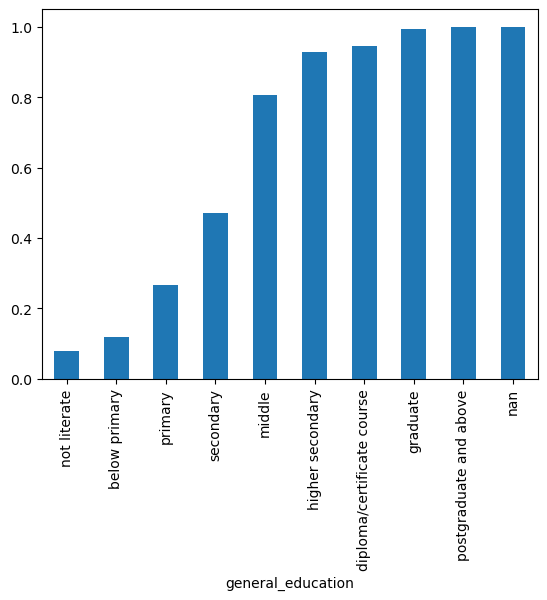

In [251]:
xx.sort_index().cumsum().plot(kind='bar')

In [252]:
drivers.groupby('current_attendance_educational_inst').apply(lambda x: x[MULT].sum() / drivers[MULT].sum()).sort_values(ascending=False)

current_attendance_educational_inst
      0.784393
12    0.186422
15    0.021277
14    0.002140
05    0.002071
13    0.001862
02    0.001097
32    0.000287
31    0.000229
37    0.000222
dtype: float64

In [253]:
drivers.groupby('technical_education').apply(lambda x: x[MULT].sum() / drivers[MULT].sum())

technical_education
diploma or certificate (below graduate level) in engineering/technology        0.011144
diploma or certificate (below graduate level) in medicine                      0.000255
diploma or certificate (below graduate level) in other subjects                0.004686
diploma or certificate (graduate and above level) in engineering/technology    0.000922
diploma or certificate (graduate and above level) in other subjects            0.001386
no technical education                                                         0.979705
technical degree in engineering/technology                                     0.000867
technical degree in other subjects                                             0.001035
dtype: float64

<AxesSubplot:xlabel='n_years_formal_education', ylabel='income'>

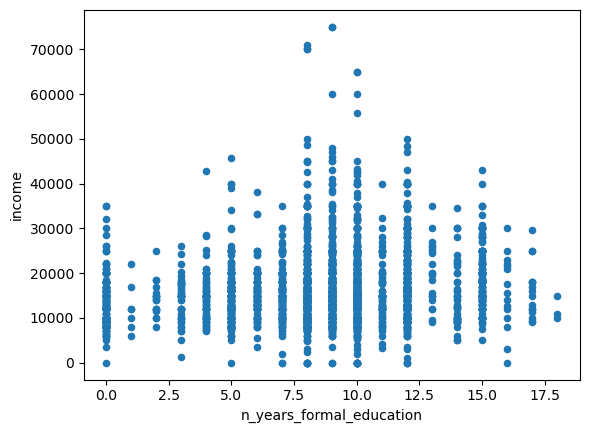

In [254]:
drivers.plot.scatter(x='n_years_formal_education', y='income')

<AxesSubplot:>

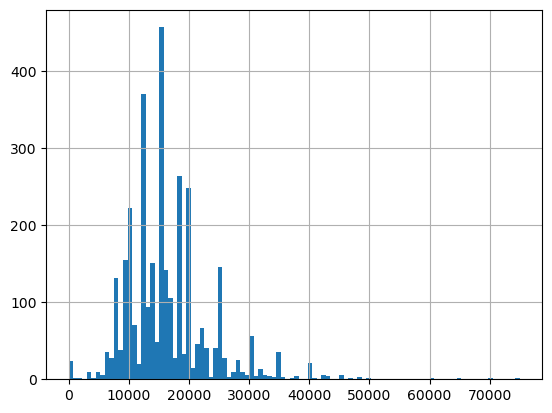

In [256]:
drivers['income'].hist(bins=100)

In [257]:
drivers.income.mean()

16348.134557495485